In [1]:
import os
import csv

from predpy.dataset import MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.wrapper import Autoencoder, Predictor, VAE
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import (
    plot_exp_predictions
)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc, get_isoforest_filter, get_variance_filter)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from predpy.experimentator import LearningParams
from tsad.noiser import apply_noise_on_dataframes, white_noise
from tsad.anomaly_detector import PredictionAnomalyDetector, ReconstructionAnomalyDetector
from models import LSTMAE, LSTMVAE
from literature.anom_trans import AnomalyTransformer, ATWrapper
from literature.velc import VELC, VELCWrapper
from literature.dagmm import DAGMM, DAGMMWrapper
from literature.tadgan import TADGAN, TADGANWrapper
from anomaly_detection.anomaly_detector_base import AnomalyDetector
from models.ideas import LSTMMVR, ConvMVR, MVRWrapper
from models import ConvAE, MultipleConvAE, ConvAEWrapper
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_dataset_names)

from pytorch_lightning.loggers import TensorBoardLogger
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import TransformerMixin
# from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch import nn
from typing import List, Dict, Literal
from predpy.plotter import plot_anomalies
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns

os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

In [2]:
window_size = 100
dataset = get_dataset(
    'data/Industry/ServerMachineDataset/test/machine-1-1.csv',
    window_size=window_size)
dataloader = DataLoader(dataset, batch_size=1)

In [3]:
exp = load_experimentator('./saved_experiments/2022-06-03_16:02:07.pkl')
model = exp.load_pl_model(0, 'checkpoints/machine-1-1/AnomTrans_l3_d512_lambda3')
a_scores = []
for i, batch in enumerate(tqdm(dataloader)):
    if i % window_size == 0:
        x = batch['sequence']
        a_score = model.anomaly_score(x, return_only_a_score=True)
        a_scores += a_score[0].tolist()
    if i == len(dataloader.dataset) - 1:
        x = batch['sequence']
        last_a_score = model.anomaly_score(x, return_only_a_score=True)
        last_a_score = last_a_score[0].tolist()

remaining_n_points = dataset.sequences[0].shape[0] % window_size
if remaining_n_points > 0:
    a_scores += last_a_score[-remaining_n_points:]

100%|██████████| 28379/28379 [00:27<00:00, 1024.18it/s]


In [4]:
assert len(a_scores) == dataset.sequences[0].shape[0]

In [5]:
test_cls_path = 'data/Industry/ServerMachineDataset/test_label/machine-1-1.csv'
data_classes = pd.read_csv(
    test_cls_path, header=None)\
    .iloc[:, 0].to_list()

In [74]:
from sklearn.linear_model import LogisticRegression

a_proportion = len(np.where(y == 1)[0]) / len(y)
x = np.array(a_scores).reshape(-1, 1).tolist()
y = np.array(data_classes)
lr = LogisticRegression(class_weight={0: a_proportion, 1: 1-a_proportion}).fit(x, y)
pred_cls = lr.predict(x).tolist()

In [76]:
lr.intercept_, lr.coef_

(array([-0.07139071]), array([[4.75412948]]))

In [72]:
len([i for i in pred_cls if i == 1])

3159

In [73]:
from sklearn.metrics import fbeta_score, confusion_matrix

cm = confusion_matrix(data_classes, pred_cls)

fbeta_score(data_classes, pred_cls, beta=1), cm

(0.3639159405433111,
 array([[23691,  2094],
        [ 1629,  1065]]))

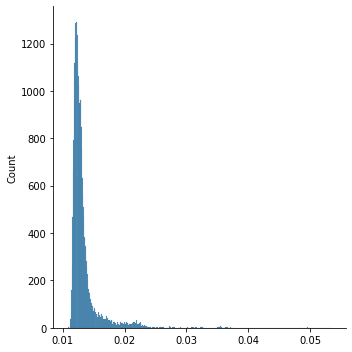

In [8]:
import seaborn as sns

sns.displot(x=a_scores);

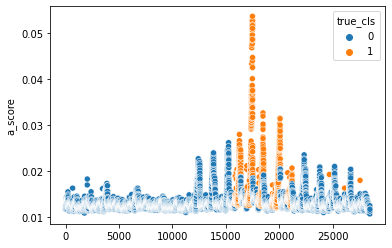

In [21]:
df = pd.DataFrame(zip(a_scores, data_classes), columns=['a_score', 'true_cls'])
sns.scatterplot(data=df, x=df.index, y='a_score', hue='true_cls');

In [81]:
pred_cls = np.zeros(df.shape[0])
ids = df[df['a_score'] > 0.025].index.tolist()
pred_cls[ids] = 1

cm = confusion_matrix(data_classes, pred_cls)
fb_score = fbeta_score(data_classes, pred_cls, beta=1, average='binary')
fb_score, cm

(0.16348773841961853,
 array([[25783,     2],
        [ 2454,   240]]))